<a href="https://colab.research.google.com/github/Chelsea-CS/parking/blob/main/CreditCard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import imutils

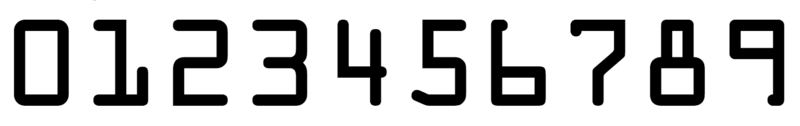

In [ ]:
path = '/content/template.jpg'

# Display the image
src = cv2.imread(path)

# Display the image, cv2.imshow() is disabled in colab, because it causes Jupyter sessions to crash, so we use cv2_imshow
cv2_imshow(src)

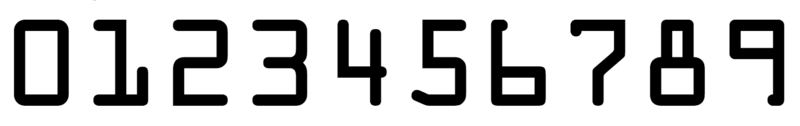

In [ ]:
# Convert to grayscale image
image = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

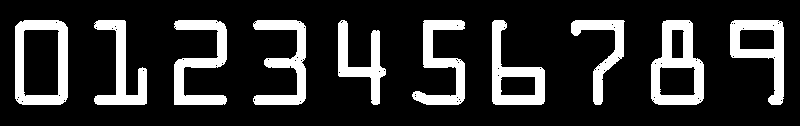

In [ ]:
# cv2.threshold(src, thresh, maxValue, thresholdingType)
# threshold function returns 2 output, first output is threshold value, second output is threshold image
ret, image = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY_INV)
cv2_imshow(image)

In [ ]:
# cv2.findContours(image, contourMode, contourApproximationMethod)
# outputs - contours, hierarchy
contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

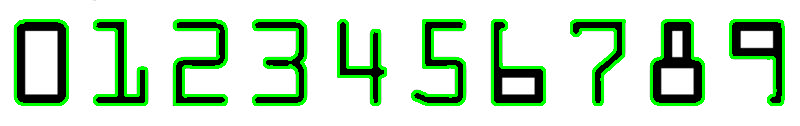

In [ ]:
# cv2.drawContours(image, contoursList, contourIndex, color, thickness)
cv2.drawContours(src, contours, -1, (0, 255, 0), 2)
cv2_imshow(src)

In [ ]:
# sort the contours

def sort_contours(cnts, method="left-to-right"):

	# initialize the reverse flag and sort index
	reverse = False
	i = 0

	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True

	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1

	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))

	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [ ]:
# based on x coordinate, sort number 0 to 9
sortedContours = sort_contours(contours, "left-to-right")[0]

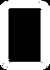

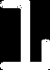

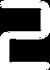

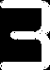

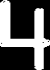

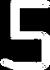

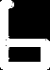

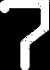

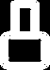

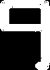

In [ ]:
# assign each contour a digit number

templates = {}

# enumerate() function adds a counter to an iterable and returns it
for (i, c) in enumerate(sortedContours):

    # x, y coordinates of the top-left corner of the rectangle, w, h - width and height of the rectangle
    (x, y, w, h) = cv2.boundingRect(c)

    digitImage = image[y : y + h, x : x + w]

    # cv2.resize(image, (width, height))
    digitImage = cv2.resize(digitImage, (50, 70))

    templates[i] = digitImage
    cv2_imshow(digitImage)

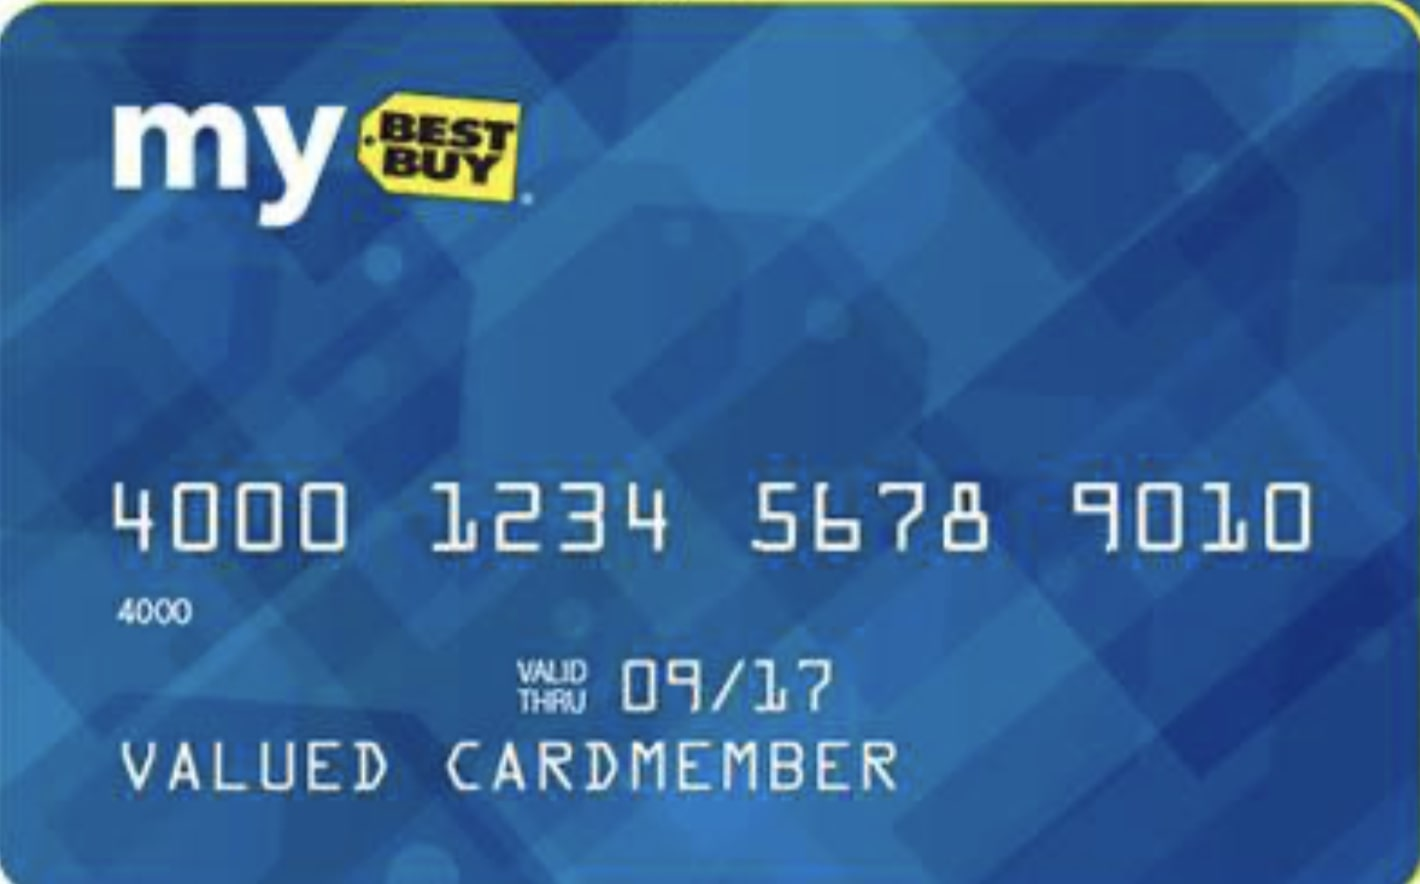

In [ ]:
# load the credit card
card = cv2.imread("card.jpg")
cv2_imshow(card)

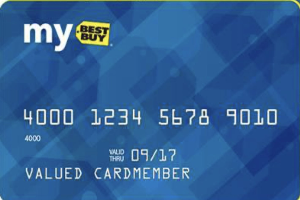

In [ ]:
# resize image to width = 300, length = 200
card = cv2.resize(card, (300, 200))
cv2_imshow(card)

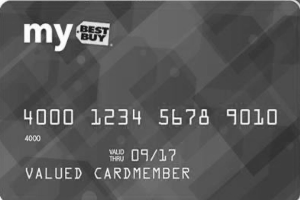

In [ ]:
# Convert to grayscale image
gray_card = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_card)

In [ ]:
# Create structuring element
rectSize =(9, 5)
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, rectSize) # MORPH_RECT means Rectangular Kernel

sqSize =(3, 3)
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, sqSize) # MORPH_RECT means Rectangular Kernel

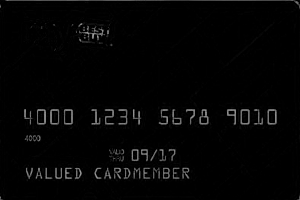

In [ ]:
# Apply morphological operation
tophat = cv2.morphologyEx(gray_card, cv2.MORPH_TOPHAT, sqKernel)
cv2_imshow(tophat)

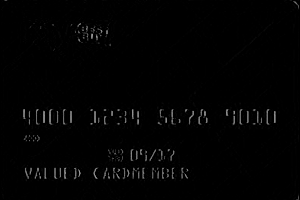

In [ ]:
# Detect the edge of the card, calculate the gradient in x direction: xorder = 1 and yorder = 0
sobelX = cv2.Sobel(tophat, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = 1)
# cv2.CV_32F means 32-bit floating-point output, dx = 1 computes the gradient in the x-direction, dy = 0 indicates that no derivative is taken in the y-direction
# k is kernel size, k = -1 means use 3*3

#sobelY = cv2.Sobel(tophat, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = 1)
cv2_imshow(sobelX)

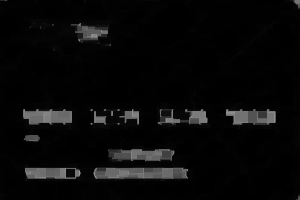

In [ ]:
# Connect the 4 digits by using close operation (Close small holes inside the foreground objects, or small black points on the object)
gradX = cv2.morphologyEx(sobelX, cv2.MORPH_CLOSE, rectKernel)
cv2_imshow(gradX)

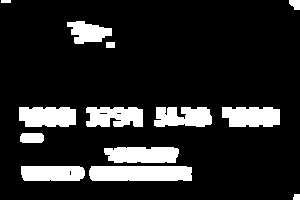

In [ ]:
# Before apply thresholding, convert the image to 8-bit unsigned integer
gradX = cv2.convertScaleAbs(gradX)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Apply dilation to fill holes and gaps
thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, rectKernel)
cv2_imshow(thresh)

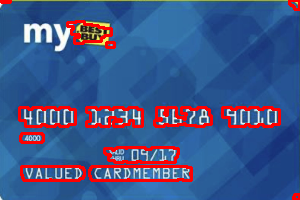

In [ ]:
# Find the external contours
cardContours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours
creditCard = card.copy()

cv2.drawContours(creditCard, cardContours, -1, (0, 0, 255), 2)
cv2_imshow(creditCard)

In [ ]:
# Calculate the aspect ratio of the rectangle contours, to check if it is the card numbers area that we are looking for
nums = []
for i, c in enumerate(cardContours):

    x, y, w, h = cv2.boundingRect(c)

    # Calculate the aspect ratio of the rectangle
    ratio = w / float(h)
    area = w * h

    if 2 <= ratio <= 4.0:
      if area > 500 and area < 1200:
        nums.append((x, y, w, h))

nums = sorted(nums, key=lambda x: x[0])
nums

[(19, 107, 57, 20), (86, 107, 57, 20), (154, 107, 58, 20), (222, 107, 58, 20)]

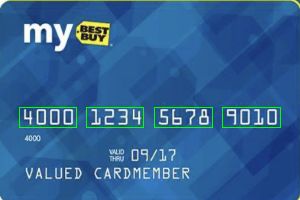

In [ ]:
# Draw the contours
bankCard = card.copy()
for (x, y, w, h) in nums:
    cv2.rectangle(bankCard, (x, y), (x + w, y + h), (0, 255, 0), 1)
cv2_imshow(bankCard)

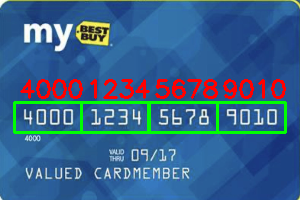

In [ ]:
for (i, (gX, gY, gW, gH)) in enumerate(nums):

    digitsOutput = []  # Each time when we recognized a digit, store it inside digitsOutput

    # Get the first group of contours
    group = gray_card[gY - 3:gY + gH + 3, gX - 3:gX + gW + 3] # [startingRowIndex: endingRowIndex, startingColumnIndex: endingColumnIndex] y coord, x coord

    # Apply thresholding
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # findContours modifies the image, so we use a copy of the image
    digitContour, _ = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the first group of contours, otherwise it will output 0004 4321 8765 0109
    digitCnts = sort_contours(digitContour, method="left-to-right")[0]
    # print(len(digitCnts)) # 4

    # Process each group of digits
    for c in digitCnts:
        # Compute the bounding rectangle of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # Get the single digit
        roi = group[y:y + h, x:x + w]
        # Resize so its size matches the template
        roi = cv2.resize(roi, (50, 70))

        scores = []
        method = cv2.TM_CCOEFF
        # Apply template Matching with each template digit in the dictionary (key - value)
        # index is the dictionary key, each digit's number, which represents 0, 1, 2, ..9
        # templateDigitImage is the template image corresponding to the digit
        for (index, templateDigitImage) in templates.items():

            # For TM_SQDIFF and MT_SQDIFF_NORMED method, the best match are the lowest values. For all the others, higher values represent better matches
            # roi is current recognizing image, templateDigitImage is the template image
            res = cv2.matchTemplate(roi, templateDigitImage, method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

            # Append the current score to the list
            scores.append(max_val)

        # argmax() returns the index of the largest element of an array
        recognized_digit = str(np.argmax(scores))

        # Appends the recognized digit to digitsOutput
        digitsOutput.append(recognized_digit) # append() method append an element to the end of the list

    # Draw a rectangle on the card
    # cv2.rectangle(image, start_point, end_point, color, thickness)
    cv2.rectangle(card, (gX - 5, gY - 5), (gX + gW + 5, gY + gH + 5), (0, 255, 0), 2)

    # Draw a text string on the card
    # cv2.putText(image, text, bottomLeftCoord, fontType, fontScale, color, thickness)
    cv2.putText(card, "".join(digitsOutput), (gX, gY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

cv2_imshow(card)

In [ ]:
# display a window for given milliseconds or until any key is pressed (if 0 is passed in the argument)
cv2.waitKey(0)

# Destroying All the windows
cv2.destroyAllWindows()